# Fourier Analysis, Wavelet Analysis, and Signal Processing

This note reviews basic operations for Fourier analysis and wavelet analysis, and demonstrate the Python implementation of the operations. The main reference is the wavelet paper by Torrence and Compo (1998), we will refer to it as TC98 later in the note.

The codes below are just some preparations at the beginning of the python code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Plot settings.
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.grid'] = 'on'
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['font.size'] = 8

## Input signal
In this note, the input signal refers to a **discrete-time signal** $x_n$, where $n=0,1,\ldots,N-1$ and $N$ is the total number of record. $x_n$ is the real-world measurement of the **continuous-time signal** $x(t)$ at certain *time resolution* $\delta t$.

Both $x_n$ and $x(t)$ are in the unit of $\mathtt{x}$. The main difference is that $x(t)$ is explicitly a function of time $t$, whereas $x_n$ maps to the discrete time $t_n=n\delta t$ through the index $n$. For $x_n$, the *duration* of the signal is $T=N\delta t$.

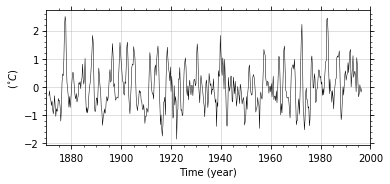

In [2]:
# Load Nino3 data.
nino3 = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
nino3 = pd.read_table(nino3)
x0 = nino3.values.squeeze()     # original data.
dt = 0.25                       # time rate, 0.25 year.
n0 = x0.size                    # original length.
t0 = 1871+0.25*np.arange(n0)    # times in year.

fig = plt.figure(figsize=(6,2.5))
ax = fig.add_axes([0.2,0.2,0.75,0.75])
ax.plot(t0,x0, 'k')
ax.set(xlim=[1870,2000], ylabel='($^{\circ}C$)', xlabel='Time (year)');

The above codes load and plot the NINO3 SST data, which is the input signal we will use. To facillitate later calculations, the input signal is padded to an integer power of 2 with zeros on both sides. For the NINO3 SST data, $N=503$, $\delta t=0.25$ yr, $T=125.75$ yr.

In [3]:
# remove DC offset, calculate the power.
x0 -= x0.mean()         # remove DC offset, make 0-freqency signal be 0.
sigma2 = np.var(x0)     # the variance, but also the power if <x[n]> = 0.

The variance $\sigma^2$ of the input signal is also the power (defined below) if the input signal is of zero-mean. As we will see shortly, the DC-offset corresponds to the Fourier coefficient at zero-frequency, and it is advantageous to let this coefficient be 0.

For certain discrete-time signal $x_n$, one can define the **energy** $E$ and the **time-averaged power** $P$:
\begin{align}
E &= \delta t\sum_{n=0}^{N-1}\left|x_n\right|^2\\
P &= \frac{\delta t}{T}\sum_{n=0}^{N-1}\left|x_n\right|^2 = \frac{1}{N}\sum_{n=0}^{N-1}\left|x_n\right|^2
\end{align}

The corresponding definitions for a continuous-time signal $x(t)$ are
\begin{align}
E &= \int_0^T dt\;\left|x(t)\right|^2\\
P &= \frac{1}{T}\int_0^T dt\;\left|x(t)\right|^2.
\end{align}

Note that the energy and power defined here is irrelevant to the energy and power in physics. It is easy to see that the power $P$ is the same as $\sigma^2$ when $\left<x_n\right>=0$.

## Fourier Analysis
The discrete Fourier transform (DFT) of the input signal $x_n$ and the inverse transform are defined as
\begin{align}
\hat{x}_k &= \frac{1}{N}\sum_{n=0}^{N-1}x_n e^{-2\pi ikn/N},\\
x_n &= \sum_{k=0}^{N-1} \hat{x}_k e^{2\pi ikn/N}.
\end{align}

Here we use "hat" version $\hat{x}$ to refer to the Fourier transform of certain quantity $x$. It should be clear that the frequency index $k=0,1,\ldots,N-1$ and the time index $n=0,1,\ldots,N-1$. As the time index $n$ maps the signal $x_n$ to time $t_n$, the frequency index $k$ maps the Fourier transform $\hat{x}_k$ to frequency $f_n$. We will re-visit the frequency index and its mapping shortly.

An important property of the Fourier transform is the **Parseval's relation**
\begin{equation}
P = \frac{1}{N}\sum_{n=0}^{N-1}\left|x_n\right|^2 = \sum_{k=0}^{N-1}\left|\hat{x}_k\right|^2.
\end{equation}

The equation says that the power is independent on whether it is counted in the time domain or frequency domain. Notice that the power in the frequency domain at each $k$ adds directly. This is the result of the normalization we used. There are other valid normalizations for DFT, as listed in Table 1.1 in *Analysis methods for multi-spacecraft data* by Paschmann and Daly (1998).

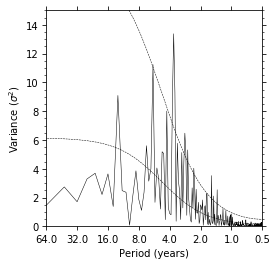

In [4]:
# Reproduce Fig 3, FFT.

# padding 0, ensure N is an integer power of 2.
N = np.int(np.power(2,np.ceil(np.log2(n0))))
T = N*dt
dn = N-n0
xn = np.pad(x0,(0,dn), 'constant', constant_values=(0,0))
tn = np.pad(t0,(0,dn), 'linear_ramp', end_values=(0,t0[-1]+dn*dt))

# Plot settings.
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['xtick.minor.top'] = False
mpl.rcParams['xtick.minor.bottom'] = False
mpl.rcParams['xtick.minor.size'] = 0
mpl.rcParams['axes.grid'] = 'off'

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.2,0.2,0.75,0.75])

ns = np.arange(N)/N     # time index, 0,1,...,N-1.
ks = np.arange(N)       # freq index, 0,1,...,N-1.
xk = np.array([sum(xn*np.exp(-2*np.pi*1j*k*ns)) for k in ks])/N    # Eq.3

fft_ps = abs(xk)**2 * 2     # power spectrum, in X^2.
fft_fk = ks/T               # frequency.

# Throw the symmetric half and the 0-frequency coefficient.
xs = 1/fft_fk[1:N//2]       # period.
ys = fft_ps[1:N//2]/(2*sigma2/N)  # normalize to power, c.f. Fig.3
ax.plot(xs, ys, 'k')
ax.set(xscale='log', xlim=[64,0.5], xlabel='Period (years)',
    ylim=[0,15], ylabel='Variance ($\sigma^2$)')
ax.xaxis.set_major_locator(plt.LogLocator(base=2,numticks=8))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# calculate mean red-noise spectrum.
series = pd.Series(xn)
# auto-correlation of lag-1 and lag-2.
alpha1 = series.autocorr(1)
alpha2 = series.autocorr(2)
alpha = (alpha1+np.sqrt(alpha2))*0.5    # see text below Eq.16
# the red-noise spectrum background.
pk = (1-alpha**2)/(1+alpha**2-2*alpha*np.cos(2*np.pi*ks[0:N//2]/N))   # Eq.16

xs = 1/fft_fk[1:N//2]
ys = pk[1:]
ax.plot(xs, ys, 'k--')

# calculate the 95% confidence level.
from scipy.stats import chi2
dof = 2     # degree-of-freedom is 2 for FFT.
confidence_level = 0.95
chiv2 = chi2.ppf(confidence_level, dof) / dof
qk = pk[1:] * chiv2  # see text left to Fig.5
ax.plot(xs, qk, 'k--');

### Fourier power spectrum
The above codes reproduce Fig. 3 in TC98. Right now, let's only focus on the solid line, which is the Fourier power spectrum normalized to $2\sigma^2/N$.

The Fourier **power spectrum** (PS) is defined as
\begin{equation}
ps_k = 2\left|x_k\right|^2.
\end{equation}

The tricky part here is that the power spectrum is only define for $k=1,2,\ldots,N/2$, which corresponds to the period $\tau_k = T/k$ from $2\delta t$ to $T$. To see why, let's look at the Fourier transform closer.

In [ ]:
xk[[0,1,255,256,257,511]]

### Frequency index $k$
The above line prints the Fourier transform $\hat{x}_k$ at several interesting places. $k=0$ corresponds to zero-frequency. It is effectively 0 because we have removed the DC-offset.

It's also easy to notice that $\hat{x}_{1} = \hat{x}^*_{511}$ and $\hat{x}_{255} = \hat{x}^*_{257}$. Indeed, for all non-zero frequency index $k=1,2,\ldots,N-1$, we have the **reality condition**
\begin{equation}
\hat{x}_k = \hat{x}^*_{N-k}.
\end{equation}

The frequency index $k$ maps the Fourier transform $\hat{x}_k$ to the **frequency** $f_k$ in the mapping rule:
\begin{equation}
f_k = \begin{cases}
   \frac{k}{T}, &k=0,1,\ldots,N/2\\
-\frac{N-k}{T}, &k=N/2,\ldots,N-1.
\end{cases}
\end{equation}
$\hat{x}_{N/2}$ ($\hat{x}_{256}$ in this case) corresponds to the Nyquist frequency $f_{Nyq} = 1/2\delta t$, which is the highest frequency can be resolved for a given time resolution $\delta t$. $\hat{x}_{N/2}$ can be mapped to either $-f_{Nyq}$ or $f_{Nyq}$.

Given the above discussion, it should be clear that why the power spectrum is defined only for $k=1,2,\ldots,N/2$. For $k>0$, energy contributions from $\pm f_k$ are equal and can be merged as $2\left|x_k\right|^2$, whereas for $k=0$, the energy contribution is 0.

The **period** $\tau_k$ that corresponds to the power spectrum is
\begin{equation}
\tau_k = T/k,\quad k=1,2,\ldots,N/2.
\end{equation}

Another common quantity in use is the **power spectral density** (PSD)
\begin{equation}
psd_k = 2T\left|x_k\right|^2.
\end{equation}
Note that the power spectrum is in the unit of $\mathtt{x}^2$ and the power spectrum density is in the unit of $\mathtt{x}^2-t$.

### Significant level and confidence level
The lower dashed line in the above figure is the mean red-noise spectrum, and the upper dashed line is the 95% confidence spectrum.

According to Section 4.a in TC98, the Fourier power spectrum for a simple red-noise model is
\begin{equation}
P_k = \frac{1-\alpha^2}{1+\alpha^2-2\alpha\cos(2\pi k/N)},
\end{equation}
where $k=1,2,\ldots,N/2$, $\alpha=(\alpha_1+\sqrt{\alpha_2})/2$, $\alpha_{1,2}$ are the lag-1 and lag-2 auto-correlations of the input signal $x_n$. For the NINO3 data, $\alpha=0.72$. The red-noise spectrum is normalized and serves as a background for significant peaks.

The 95% confidence spectrum is calculated based on the red-noise spectrum.
\begin{equation}
    Q_k = P_k \;\chi^2(\nu_0,c),
\end{equation}
where $c=0.95$ is the specified confidence level, $\nu_0$ is the **degree of freedom** ($\nu_0=2$ for Fourier transform). Both of them are inputs for the $\chi^2$ distribution.

# Wavelet function
In this section, we implement the several wavelet functions introduced in TC98. This is a preparation for next section, where we implement the continuous wavelet transform.

In [5]:
# Reproduce Fig 2.
# Define wavelet functions.
def morlet(eta,w0=6):
    return np.power(np.pi,-0.25)*np.exp(eta*(-0.5*eta+(0+1j)*w0))

def paul(eta, m=4):
    return np.power(2j,m)*np.math.factorial(m)/np.sqrt(np.pi*np.math.factorial(2*m))*np.power(1-eta*(0+1j),-m-1)

from scipy.special.orthogonal import hermitenorm
from numpy.lib.polynomial import polyval
from scipy.special import gamma

def dog(eta, m=2):
    return np.power(-1,np.mod(m+1,2))*polyval(hermitenorm(m),eta)*np.exp(-0.5*eta**2)/np.sqrt(gamma(m+0.5))

def morletf(sw, w0=6):
    return np.power(np.pi,-0.25)*np.exp(-0.5*(sw-w0)**2)*(sw>0)

def paulf(sw, m=4):
    return np.power(2,m)/np.sqrt(m*np.math.factorial(2*m-1))*np.power(sw,m)*np.exp(-sw)*(sw>0)

def dogf(sw, m=2):
    return -np.power(1j,m)/np.sqrt(gamma(m+0.5))*np.power(sw,m)*np.exp(-0.5*sw**2)

For a generic wavelet function $\psi_0(z)$, it's easy to calculate its Fourier transform $\hat{\psi}_0(z)$. For both of them the subscript 0 indicates they are the mother wavelet function.

Based on Table 1 in TC98, three commonly used mother wavelet functions and their Fourier tranforms are
* Morlet. $\omega_0$ is the free parameter. $\omega_0=6$ in the paper.
\begin{align}
\psi_0(z) &= \pi^{-1/4}e^{i\omega z}e^{-z^2/2}\\
\hat{\psi}_0(z) &= \pi^{-1/4} H(z) e^{-(z-\omega_0)^2/2}.
\end{align}
* Paul. $m$ is the free parameter. $m=4$ in the paper.
\begin{align}
\psi_0(z) &= \frac{2^m i^m m!}{\sqrt{\pi(2m)!}}(1-iz)^{-(m+1)}\\
\hat{\psi}_0(z) &= \frac{2^m}{\sqrt{m(2m-1)!}}H(z) z^m e^{-z}.
\end{align}
* DOG (derivative of a Gaussian). $m$ is the free parameter. $m=2,6$ in the paper.
\begin{align}
\psi_0(z) &= \frac{(-1)^{m+1}}{\sqrt{\Gamma(m+1/2)}}\frac{d^m e^{-z^2/2}}{d\tau^m}\\
\hat{\psi}_0(z) &= \frac{-i^{m}}{\sqrt{\Gamma(m+1/2)}}\eta^m e^{-z^2/2}.
\end{align}
In above equations
\begin{equation}
H(z) = \begin{cases}
1 & z>0\\
0 & z\leq 0.
\end{cases}
\end{equation}

Run the codes below and check the waveforms of these wavelet functions.

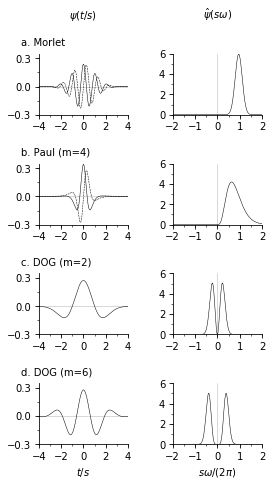

In [6]:
# Plot settings.
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.minor.top'] = False
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.minor.right'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


fig = plt.figure(figsize=(4,7))
fig.subplots_adjust(wspace=0.5, hspace=0.8, top=0.9)

t = np.linspace(-4,4,500,endpoint=True)
dt = t[1]-t[0]
s = 10*dt
eta = np.zeros(len(t), dtype=complex)
eta.real = t
sw = np.linspace(-2,2,500,endpoint=True)

# a. Morlet
ax = fig.add_subplot(421)
psi0 = morlet(eta)
psi = psi0*np.sqrt(dt/s)
ax.set(xlim=[-4,4], ylim=[-0.3,0.35])
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.15))
ax.axhline(color='black',alpha=0.3)
ax.plot(t,psi.real, 'k-')
ax.plot(t,psi.imag, 'k--')
ax.text(-0.2,1.1, 'a. Morlet', ha='left',va='bottom', transform=ax.transAxes)
ax.text(0.5,1.5, '$\psi(t/s)$', ha='center',va='bottom', transform=ax.transAxes)


# b. Paul (m=4)
ax = fig.add_subplot(423)
psi0 = paul(eta)
psi = psi0*np.sqrt(dt/s)
ax.set(xlim=[-4,4], ylim=[-0.3,0.35])
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.15))
ax.axhline(color='black',alpha=0.3)
ax.plot(t,psi.real, 'k-')
ax.plot(t,psi.imag, 'k--')
ax.text(-0.2,1.1, 'b. Paul (m=4)', ha='left',va='bottom', transform=ax.transAxes)


# c. DOG (m=2)
ax = fig.add_subplot(425)
psi0 = dog(eta)
psi = psi0*np.sqrt(dt/s)
ax.set(xlim=[-4,4], ylim=[-0.3,0.35])
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.15))
ax.axhline(color='black',alpha=0.3)
ax.plot(t,psi.real, 'k-')
ax.text(-0.2,1.1, 'c. DOG (m=2)', ha='left',va='bottom', transform=ax.transAxes)


# d. DOG (m=6)
ax = fig.add_subplot(427)
psi0 = dog(eta, m=6)
psi = psi0*np.sqrt(dt/s)
ax.set(xlim=[-4,4], ylim=[-0.3,0.35])
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.15))
ax.axhline(color='black',alpha=0.3)
ax.plot(t,psi.real, 'k-')
ax.set(xlabel='$t/s$')
ax.text(-0.2,1.1, 'd. DOG (m=6)', ha='left',va='bottom', transform=ax.transAxes)


# a'. Morlet
ax = fig.add_subplot(422)
ax.text(0.5,1.5, '$\hat{\psi}(s\omega)$', ha='center',va='bottom', transform=ax.transAxes)
psi0 = morletf(sw * 2 * np.pi)
psi = psi0*np.sqrt(2*np.pi*s/dt)
ax.set(xlim=[-2,2], ylim=[0,6])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.axvline(color='black',alpha=0.3)
ax.plot(sw,psi.real, 'k-')

# b'. Paul
ax = fig.add_subplot(424)
psi0 = paulf(sw * 2 * np.pi)
psi = psi0*np.sqrt(2*np.pi*s/dt)
ax.set(xlim=[-2,2], ylim=[0,6])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.axvline(color='black',alpha=0.3)
ax.plot(sw,psi.real, 'k-')

# c'. DOG
ax = fig.add_subplot(426)
psi0 = dogf(sw * 2 * np.pi)
psi = psi0*np.sqrt(2*np.pi*s/dt)
ax.set(xlim=[-2,2], ylim=[0,6])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.axvline(color='black',alpha=0.3)
ax.plot(sw,psi.real, 'k-')

# d'. DOG
ax = fig.add_subplot(428)
psi0 = dogf(sw * 2 * np.pi, m=6)
psi = psi0*np.sqrt(2*np.pi*s/dt)
ax.set(xlim=[-2,2], ylim=[0,6])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.axvline(color='black',alpha=0.3)
ax.plot(sw,psi.real, 'k-')
ax.plot(sw,psi.imag, 'k-')
ax.set(xlabel='$s\omega/(2\pi)$');

The above plot reproduces Fig. 2 in TC98. What are plotted are the daughter wavelet functions $\psi_s$ and $\hat{\psi}_s$ for $s/\delta t = 10$.

For a certain scale $s$, the mother and daughter wavelet functions differ in normalization, as given by Equation 6 and 8 in TC98
\begin{align}
\psi_s(z) &= \sqrt{\delta t/s}\; \psi_0(z)\\
\hat{\psi}_s(z) &= \sqrt{2\pi s/\delta t}\; \hat{\psi}_0(z).
\end{align}

To be clear, later in the note, we will stick to the mother wavelet function $\psi_0$ and $\hat{\psi}_0$, and write the normalization explicitly.

The Morlet and Paul wavelets are complex, thus their $\psi$ have both the real (solid line) and imaginary (dashed line) parts. The DOG wavelet is real, thus its $\psi$ only has the real (solid line) part, and its $\hat{\psi}$ is symmetric around 0. (Remember the reality condition leads that for a real-valued signal, the real part of its Fourier transform is symmetric around the zero-frequency.)

## Wavelet Analysis
Wavelet analysis is one step forward than Fourier analysis. Similar to Fourier analysis, wavelet analysis can reveal the power distribution in the frequency domain, characterized by the scale index $j$, which is the counterpart of frequency index $k$ in Fourier analysis. In addition, wavelet analysis also reveals the power distribution in the time domain, characterized by the time index $n$.

The **continuous wavelet transform** (CWT) of the input signal $x_n$ is a complex-valued quantity, depends on the scale index $j$ and the time index $n$. It can be calculated in the time domain
\begin{equation}
W_{n,j} = \sum_{l=0}^{N-1} x_l \sqrt{\frac{\delta t}{s_j}}\psi^*_0 \left[\frac{(l-n)\delta t}{s_j}\right],
\end{equation}
or equivalently in the frequency domain
\begin{equation}
W_{n,j} = \sum_{k=0}^{N-1} \hat{x}_k \sqrt{\frac{2\pi s_j}{\delta t}}\hat{\psi}^*_0(2\pi k s_j/T) e^{2\pi ikn/N}.
\end{equation}
The codes below implement the CWT in the time domain and reproduces Fig. 1 in TC98.

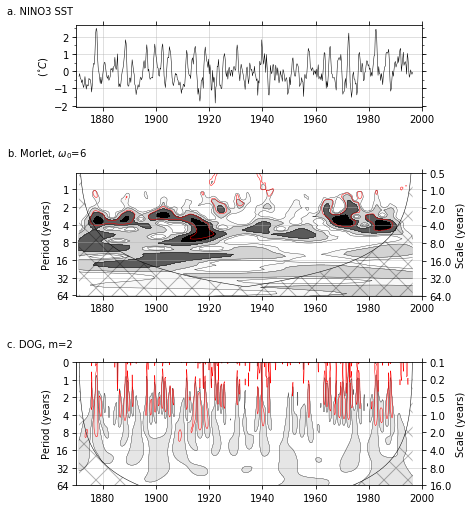

In [175]:
#### Reproduce Fig 1.

# Plot settings.
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.grid'] = 'on'

unit ='($^{\circ}C$)'
label ='NINO3 SST'

fig = plt.figure(figsize=(8,8))
gs = plt.GridSpec(3,1,height_ratios=[2,3,3])
gs.update(left=0.2, right=0.8, hspace=0.6, top=0.9, bottom=0.1)

# a. Nino3 time series.
ax = plt.subplot(gs[0])
ax.plot(t0, x0, color='black')
ax.set(xlim=[1870,2000], ylabel=unit)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.text(-0.2,1.1, 'a. NINO3 SST', ha='left',va='bottom', transform=ax.transAxes)

dt = 0.25
T = n0*dt
xn = (x0-x0.mean())/x0.std()
xn = np.pad(xn,(0,dn), 'constant', constant_values=(0,0))

# b. Morlet CWT
# make scale.
s0 = 2*dt
s1 = 64
dj = 0.125
J = np.int(np.log2(s1/s0)/dj)+1
sj = s0*np.power(2,dj*np.arange(J))

# In time domain.
wns = np.empty((N,J),dtype=complex)
for n in range(N):
    for j in range(J):
        z = (np.arange(N)-n)*dt/sj[j]
        wns[n,j] = sum(xn*np.conjugate(morlet(z)))*np.sqrt(dt/sj[j])

## In freq domain.
#wns = np.empty((N,J),dtype=complex)
#xk = np.fft.fft(xn, N)
#wk = np.fft.fftfreq(N,dt)*2*np.pi
#for j in range(J):
#    daughter = np.sqrt(2*np.pi*sj[j]/dt)*morletf(sj[j]*wk)
#    wns[:,j] = np.fft.ifft(xk*daughter)

wns = wns[0:N-dn,:]
cwtpower = np.abs(wns)**2
vs = [1,2,5,10]

# Fourier wavelength.
w0 = 6
s2t = 4*np.pi/(w0+np.sqrt(2+w0**2))
tauj = sj*s2t
ylim = np.array([64,0.5])

# main contour.
xi, yi = np.meshgrid(t0, tauj)
zi = np.transpose(np.copy(cwtpower))
ax = plt.subplot(gs[1])
ax.yaxis.tick_left()
ax.contourf(xi, yi, zi, vs, cmap='Greys', extend='max')
ax.contour(xi, yi, zi, vs, colors='black', linewidths=0.3)
ax.text(-0.2,1.1, 'b. Morlet, $\omega_0$=6', ha='left',va='bottom', transform=ax.transAxes)

# Wavelet power spectrum and periods for later code.
wps_nj = cwtpower
lambdas = tauj

# Add 95% confidence level.
gamma0 = 2.32   # Table 2.
pj = (1-alpha**2)/(1+alpha**2-2*alpha*np.cos(2*np.pi*dt/tauj))
dof = 2
chiv2 = chi2.ppf(confidence_level, dof) / dof
qj = pj * chiv2
for j in range(J): zi[j,:] /= qj[j]
ax.contour(xi,yi, zi, [-99,1], colors='red', linewidths=0.5)

# Add 2nd y-axis for the scale.
ax2 = fig.add_subplot(gs[1], sharex=ax, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.grid(False)
ax2.get_xaxis().set_visible(False)
ax2.yaxis.set_label_position("right")
ax2.set(ylim=ylim, yscale='log', ylabel='Scale (years)')
ax2.yaxis.set_major_locator(plt.LogLocator(base=2,numticks=8))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax2.yaxis.set_minor_locator(plt.NullLocator())

# Add COI. Table 1, e-folding time.
tmid = 0.5*(t0[0]+t0[-1])
coi = (T*0.5-abs(t0-tmid))/np.sqrt(2)
ax2.plot(t0, coi, lw=0.5, color='black')
ax2.fill_between(t0, coi, y2=1e5, lw=0, facecolor='none', hatch='X', edgecolor='black', alpha=0.3)
ax.set(xlim=[1870,2000], ylim=ylim*s2t, yscale='log', ylabel='Period (years)')
ax.yaxis.set_major_locator(plt.LogLocator(base=2,numticks=8))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(plt.NullLocator())


# b. DOG CWT
# make scale.
s0 = 0.125
s1 = 16
dj = 0.125
J = np.int(np.log2(s1/s0)/dj)+1
sj = s0*np.power(2,dj*np.arange(J))

# In time domain.
wns = np.empty((N,J),dtype=complex)
for n in range(N):
    for j in range(J):
        wns[n,j] = sum(xn*np.conjugate(dog((np.arange(N)-n)*dt/sj[j])))*np.sqrt(dt/sj[j])

## In freq domain.
#wns = np.empty((N,J),dtype=complex)
#xk = np.fft.fft(xn, N)
#wk = np.fft.fftfreq(N,dt)*2*np.pi
#for j in range(J):
#    daughter = np.sqrt(2*np.pi*sj[j]/dt)*dogf(sj[j]*wk)
#    wns[:,j] = np.fft.ifft(xk*daughter)

wns = wns[0:N-dn,:]
cwtpower = np.abs(wns)**2
vs = [2,100]
colors = ['0.9','0.9']

# Fourier wavelength.
m = 2
s2t = 2*np.pi/np.sqrt(m+0.5)
tauj = sj*s2t
ylim = np.array([16,0.125])

# main contour.
xi, yi = np.meshgrid(t0, tauj)
zi = np.transpose(np.copy(cwtpower))
ax = plt.subplot(gs[2])
ax.yaxis.tick_left()
ax.contourf(xi, yi, zi, vs, colors=colors, extend='max')
ax.contour(xi, yi, zi, vs, colors='black', linewidths=0.3)
ax.text(-0.2,1.1, 'c. DOG, m=2', ha='left',va='bottom', transform=ax.transAxes)

# Add 95% confidence level.
gamma0 = 1.43   # Table 2.
pj = (1-alpha**2)/(1+alpha**2-2*alpha*np.cos(2*np.pi*dt/tauj))
dof = 1
chiv2 = chi2.ppf(confidence_level, dof) / dof
qj = pj * chiv2
for j in range(J): zi[j,:] /= qj[j]
ax.contour(xi,yi, zi, [-99,1], colors='red', linewidths=0.5)

# Add 2nd y-axis for the scale.
ax2 = fig.add_subplot(gs[2], sharex=ax, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.grid(False)
ax2.get_xaxis().set_visible(False)
ax2.yaxis.set_label_position("right")
ax2.set(ylim=ylim, yscale='log', ylabel='Scale (years)')
ax2.yaxis.set_major_locator(plt.LogLocator(base=2,numticks=8))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax2.yaxis.set_minor_locator(plt.NullLocator())

# Add COI. Table 1, e-folding time.
tmid = 0.5*(t0[0]+t0[-1])
coi = (T*0.5-abs(t0-tmid))/np.sqrt(2)*s2t
ax.plot(t0, coi, lw=0.5, color='black')
ax.fill_between(t0, coi, y2=1e5, lw=0, facecolor='none', hatch='X', edgecolor='black', alpha=0.3)
ax.set(xlim=[1870,2000], ylim=ylim*s2t, yscale='log', ylabel='Period (years)')
ax.yaxis.set_major_locator(plt.LogLocator(base=2,numticks=8))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(plt.NullLocator())

### Scale index $j$
Similar to the frequency index $k$ in the Fourier transform, the wavelet transform has a scale index $j$, for the dimension of frequency domain. The scales $s_j$ are in the unit of $t$, and convert to periods $\tau_j$ by $c_{\lambda} = \tau_j/s_j$. From Table 1 in TC98
* Morlet. $c_\lambda = \cfrac{4\pi}{\omega_0 + \sqrt{2+\omega_0}}$. For example, $\tau_j \simeq 1.033 s_j$ for $\omega_0 = 6$.
* Paul. $c_\lambda = \cfrac{4\pi}{2m+1}$. For example, $\tau_j \simeq 1.396 s_j$ for $m=4$.
* DOG. $c_\lambda = \cfrac{2\pi}{\sqrt{m+1/2}}$. For example, $\tau_j \simeq 3.974 s_j$ for $m=2$.

In the above plot, $\tau_j$ are the y-axis on the left and $s_j$ are the y-axis on the right. For example in panel c, the conversion coefficient is 3.974 for DOG $m=2$, hence the period is roughly 4 times of the corresponding scale.

Different from the Fourier transform, there is freedom to choose scales $s_j$. One can generate $s_j$ by setting the smallest scale $s_0$, the step  of power $\delta j$, and the number of scales $J$
\begin{equation}
s_j = s_0 2^{j\delta j},\quad j=0,1,\ldots,J-1.
\end{equation}
As seen from panel b and c in the above plot, the scales are chosen to make the period ranges from 0.5 to 64 yr. Recall that $\delta t=0.25$ yr and $T = 128$ yr, this period range corresponds to $2\delta t$ and $T/2$ respectively. In terms of $\delta j$, it is usually set to be $0.125$ or $0.25$.

### Cone of influence (COI)
The cross hatched regions in panel b and c in the above plot correspond to the **cone of influence**, which marks the region affected by the boundary effect. For the time $t_n$, one can defind the time difference from the center $\Delta t_n = 0.5T - |t_n-t_0-0.5T|$. Every $\Delta t_n$ corresponds to a scale $s_n$. At the scale $s_n$, times within $\Delta t_n$ on both boundaries are affected by the boundary effect. From Table 1 in TC98, the conversion constant $c_{COI} = s_n/\Delta t_n$ depends on type of wavelet. 
* Morlet. $1/\sqrt{2}$.
* Paul. $\sqrt{2}$.
* DOG. $1/\sqrt{2}$.

To be specific, the COI is a function of time $t_n$, and its value can be expressed in terms of either scales $s_n$ or periods $\tau_n$.
* For scale, COI's values are $s_n = \Delta t_n c_{COI}$.
* For period, COI's values are $\tau_n = c_\lambda \Delta t_n c_{COI}$.

### Wavelet power spectrum
Similar to the Fourier power spectrum, the **wavelet power spectrum** is
\begin{equation}
wps_{n,j} = \left|W_{n,j}\right|^2.
\end{equation}

The wavelet power spectrum is in the unit of $\mathtt{x}^2$, defined for $n=0,1,\ldots,N-1$ and $j=0,1,\ldots,J-1$. Consequently, averaging over time defines the **global wavelet spectrum** (GWS), which gives the power distribution in the frequency domain. And averaging over scale defines the **scale-averaged wavelet power** (SWP), which gives the power distribution in the time domain. We will compare the former to the Fourier power spectrum, but the latter is what missed by the Fourier analysis.
\begin{align}
gws_j &= \frac{1}{N} \sum_{n=0}^{N-1} {\left|W_{n,j}\right|^2},\\
swp_n &= \frac{\delta j\delta t}{C_\delta} \sum_{j=0}^{J-1} \frac{\left|W_{n,j}\right|^2}{s_j}.
\end{align}

### Confidence level for WPS
The last point about the above plot is the red contours in panel b and c. They are the 95% confidence level $Q_j$ defined on each scale $s_j$. It's definition is the same as the Fourier transform. The only difference is that now $Q_j$ is defined on the scale index $j$.

According to Section 4.a in TC98, the red-noise background is
\begin{equation}
P_j = \frac{1-\alpha^2}{1+\alpha^2-2\alpha\cos(2\pi\delta t/\tau_j)},
\end{equation}
where $j=0,2,\ldots,J-1$, $\alpha=(\alpha_1+\sqrt{\alpha_2})/2$, $\alpha_{1,2}$ are the lag-1 and lag-2 auto-correlations of the input signal $x_n$.

The 95% confidence spectrum is calculated based on the red-noise spectrum.
\begin{equation}
    Q_j = P_j \;\chi^2(\nu_0,c),
\end{equation}
where $c=0.95$ is the specified confidence level, $\nu_0$ is the **degree of freedom**. $\nu_0 = 2$ for complex wavelets (Morlet and Paul), and $\nu_0 = 1$ for real wavelts (DOG). Both of them are inputs for the $\chi^2$ distribution.

The $Q_j$ applies to all times for the wavelet power spectrum, therefore the contour of $WPS_nj = Q_j$ is equivalent to the contour of $wps_{nj}/Q_j = 1$.

### Global wavelet spectrum (GWS)
Now we compare the global wavelet spectrum 
\begin{equation}
gws_j = \frac{1}{N} \sum_{n=0}^{N-1} {\left|W_{n,j}\right|^2}
\end{equation}
to its counterpart in Fourier analysis: the Fourier power spectrum.

Here are the codes:

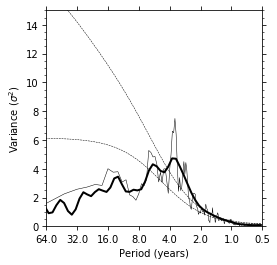

In [160]:
# Reproduce Fig 6.
# GWS vs FFT.
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['xtick.minor.top'] = False
mpl.rcParams['xtick.minor.bottom'] = False
mpl.rcParams['xtick.minor.size'] = 0
mpl.rcParams['axes.grid'] = 'off'

def smooth(x0, N):
    n1 = N // 2
    n2 = N - n1

    x1 = np.pad(x0, (n1, n2), 'constant', constant_values=(0, 0))
    x2 = np.empty(len(x0), dtype=float)
    x2[0] = sum(x1[0:N])
    for i in range(1, len(x0)):
        x2[i] = x2[i - 1] - x1[i - 1] + x1[N + i - 1]
    return x2 / N

xs = 1/fft_fk[1:n0//2]   # period.
ys = smooth(fft_ps, 5)[1:n0//2]*(N/(2*sigma2))  # Fourier PS, 5-point smoothed.

fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
ax.plot(xs, ys, color='black')
ax.plot(lambdas, gws, lw=2, color='black')

gws = np.sum(wps_nj,0)/N  # Eq.22

# significance level.
from scipy.stats import chi2

gamma0 = 2.32   # Table 2. Morlet w0 = 6.
s2t = 4*np.pi/(w0+np.sqrt(2+w0**2))
sj = lambdas/s2t
pj = (1-alpha**2)/(1+alpha**2-2*alpha*np.cos(2*np.pi*dt/lambdas))
ax.plot(lambdas, pj, 'k--')
dof = 2*np.sqrt(1 + (N*dt/(gamma0*sj))**2)   # Eq (23).
chiv2 = chi2.ppf(confidence_level, dof) / dof
ys = pj * chiv2
ax.plot(lambdas, ys, 'k--')

ax.set(xscale='log', xlim=[64, 0.5], xlabel='Period (years)',
       ylim=[0, 15], ylabel='Variance ($\sigma^2$)')
ax.xaxis.set_major_locator(plt.LogLocator(base=2, numticks=8))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(plt.NullLocator());

The above plot reproduces Fig. 6 in TC98. The thick solid line is the global wavelet spectrum, whereas the thin solid line is the Fourier power spectrum after a 5-point running average. The lower and upper dashed lines are the mean red-noise spectrum and the 95% confidence level. Note that the 2 dashed lines here are based on the wavelet analysis, which are conceptually different from those in the section on Fourier analysis.

#### Confidence level for GWS

As discussed in Section 5.a in TC98, the red-noise spectrum for Fourier analysis applies to wavelet analysis. This is the same red-noise spectrum when we discuss the red contours for the wavelet power spectrum.
\begin{equation}
P_j = \frac{1-\alpha^2}{1+\alpha^2-2\alpha\cos(2\pi\delta t/\tau_j)},
\end{equation}
where the subscript $j$ indicates that $P_j$ maps to the scale index $j=0,1,\ldots,J-1$.

And the 95% confidence spectrum for the global wavelet spectrum is
\begin{equation}
    Q_j = P_j \;\chi^2(\nu_j,c),
\end{equation}
However, for GWS, the degree of freedom is a function of the scale index $j$:
\begin{equation}
\nu_j = \nu_0\sqrt{1+\left(\frac{N\delta t}{\gamma s_j}\right)^2},
\end{equation}
where $\gamma$ is a constant called **decorrelation factor** which depends on the choice of wavelet. According to Table 2 in TC98,
* Morlet. $\gamma=2.32$ for $\omega_0=6$.
* Paull. $\gamma=1.17$ for $m=4$.
* DOG. $\gamma=1.43$ for $m=2$ and $\gamma=1.37$ for $m=6$.

### Scale-averaged wavelet power (SWP)
Next, we examine the scale-averaged wavelet power
\begin{equation}
swp_n = \frac{\delta j\delta t}{C_\delta} \sum_{j=0}^{J-1} \frac{\left|W_{n,j}\right|^2}{s_j},
\end{equation}
for averaging over all scales; or
\begin{equation}
swp_n = \frac{\delta j\delta t}{C_\delta} \sum_{j=j_1}^{j_2} \frac{\left|W_{n,j}\right|^2}{s_j},
\end{equation}
for averaging from the scale index $j_1$ to $j_2$. The total number of scales get averaged is $n_a = j2-j1+1$.

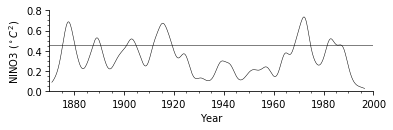

In [122]:
# Reproduce Fig. 8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.minor.top'] = False
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.minor.right'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


Cdelta = 0.776  # Table 2.
dj0 = 0.60      # Table 2.
index = [i for i, s in enumerate(sj) if 2<=s<=8]
na = len(index)

# The scale-averaged wavelet power.
swp_n = dj*dt/Cdelta*np.sum(wps_nj[:,index]/sj[index],1)*sigma2   # Eq.24

# confidence level.
s_avg = 1/np.sum(1/sj[index])                   # Eq. 25
s_mid = sj[0]*np.power(2,0.5*(index[0]+index[-1])*dj)
dof = 2*na*s_avg/s_mid*np.sqrt(1+(na*dj/dj0)**2)# Eq. 28
pbar = s_avg * sum(pj[index]/sj[index])         # Eq. 27
chiv2 = chi2.ppf(confidence_level, dof) / dof
Q = (dj*dt/Cdelta/s_avg)*pbar*chiv2*sigma2      # Eq. 26


fig = plt.figure(figsize=(6,1.5))
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
ax.plot(t0, swp_n, color='black')
ax.axhline(y=Q, color='black')
ax.set(xlim=(1870,2000), ylim=(0,0.8), xlabel='Year', ylabel='NINO3 ($^\circ C^2$)');

The above plot shows the scale-averaged wavelet power $swp_n$, which is a function of time $t_n$, for the subset of scales $s_j \in [2,8]$ yr.

#### Confidence level for SWP
The 95% confidence level for SWP is different from GWS and WPS. For SWP, the confidence level is a number $Q$, based on Equation (26) in TC98,
\begin{equation}
Q = \frac{\delta j\delta t\sigma^2}{C_\delta S_{avg}}\overline{P}\frac{\chi_\nu^2}{\nu},
\end{equation}
where from Equation (25) and (27) in TC98,
\begin{align}
S_{avg} &= 1/\sum_{j=j_1}^{j_2}1/s_j,\\
\overline{P} &= S_{avg}\sum_{j=j_1}^{j_2}\frac{P_j}{s_j},
\end{align}
$P_j$ is the same red-noise spectrum defined for GWS and WPS. $C_\delta$ is the **recontruction factor**, a constant depends on wavelet (Table 2 in TC98):
* Morlet. $C_\delta = 0.776$ for $\omega_0 = 6$.
* Paul. $C_\delta = 1.132$ for $m=4$.
* DOG. $C_\delta = 3.541$ for $m=2$, and $C_\delta = 1.966$ for $m=6$.

The $\nu$ again is the degree of freedom, but defined differently for SWP, from Equation (28) in TC98,
\begin{equation}
\nu = \frac{\nu_0 n_a S_{avg}}{S_{mid}} \sqrt{1+\left(\frac{n_a\delta j}{\delta j_0}\right)^2},
\end{equation}
where $n_a = j2-j1+1$, $S_{mid} = s_0\,2^{\delta j(j_1+j_2)/2}$, and $\delta j_0$ is the **factor for scale averaging**, a constant depends on wavelet (Table 2 in TC98):
* Morlet. $\delta j_0 = 0.60$ for $\omega_0 = 6$.
* Paul. $\delta j_0 = 1.5$ for $m=4$.
* DOG. $\delta j_0 = 1.4$ for $m=2$, and $\delta j_0 = 0.97$ for $m=6$.

# Summary
In this note, I reviewed
1. The Fourier transform, its red-noise spectrum and 95% confidence level;
2. The mother wavelet functions, including Morlet ($\omega_0=6$), Paul ($m=4$), DOG ($m=2,6$);
3. The continuous wavelet transform (CWT) in the time domain and frequency domain;
    1. The wavelet power spectrum (WPS) and its 95% confidence level;
    2. The global wavelet spectrum (GWS) and its 95% confidence level;
    3. The scale-averaged wavelet power (SWP) and its 95% confidence level.
Figures in TC98 are reproduced with Python code. The purpose of the code is to show every computation detail for the equations in the paper. Developing more abstract functions is not pursued here.

Materials for Section 6 in TC98 covers extensions to wavelet analysis, which I don't have the energy to pursue further.